In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor


In [2]:

def serrf_normalization(df, qc_label='qc', n_estimators=500, random_state=0):
    """
    Perform SERRF normalization.
    
    Parameters:
    - df: pandas DataFrame with MultiIndex columns [batch, sampleType, time, label] 
          and MultiIndex rows [No, analyte].
    - qc_label: the value in the sampleType level indicating QC samples (case-insensitive).
    - n_estimators: number of trees in the random forest.
    - random_state: random state for reproducibility.
    
    Returns a DataFrame of the same shape with batch-corrected intensities.
    """
    # Identify QC samples
    sample_types = df.columns.get_level_values(1)
    qc_mask = sample_types.str.lower() == qc_label.lower()
    qc_cols = df.columns[qc_mask]
    
    # Extract metadata: batch (level 0) and time/order (level 2)
    batch = df.columns.get_level_values(0).astype(str)
    time = df.columns.get_level_values(2).astype(float)
    meta = pd.get_dummies(
        pd.DataFrame({'batch': batch, 'time': time}, index=df.columns),
        columns=['batch'], drop_first=False
    )
    
    # Calculate QC means and stds for autoscaling
    qc_data = df[qc_cols]
    qc_mean = qc_data.mean(axis=1)
    qc_std = qc_data.std(axis=1, ddof=0).replace(0, 1)
    
    # Autoscale all data based on QC statistics
    scaled = df.sub(qc_mean, axis=0).div(qc_std, axis=0)
    scaled_qc = scaled[qc_cols]
    
    # Prepare output DataFrame
    corrected = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)
    i=0
    # Iterate over each metabolite/feature
    for feat in df.index:
        #print(i)
        # Response: scaled QC intensities for this feature
        y = scaled_qc.loc[feat].values
        
        # Predictors: meta + scaled QC of all other features
        X_other = scaled_qc.drop(index=feat).T.values
        X_meta = meta.loc[qc_cols].values
        X = np.hstack([X_meta, X_other])
        
        # Train Random Forest
        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
        rf.fit(X, y)
        
        # Predict systematic error for all samples
        X_other_all = scaled.drop(index=feat).T.values
        X_meta_all = meta.values
        X_all = np.hstack([X_meta_all, X_other_all])
        s_scaled = rf.predict(X_all)
        
        # Revert autoscaling to get error estimates
        s = s_scaled * qc_std.loc[feat] + qc_mean.loc[feat]
        
        # Apply normalization: I' = I / s * mean(I)
        I = df.loc[feat].values
        corrected.loc[feat] = I / s * I.mean()
        i+=1
    return corrected



In [3]:
# Load and test on the provided example dataset
path = '../data/SERRF example dataset - with validate (4).xlsx'
df_raw = pd.read_excel(path, header=[0,1,2,3], index_col=[0,1])
df_corrected = serrf_normalization(df_raw, qc_label='QC', n_estimators=10)

# Display the top-left corner of the corrected DataFrame
print(df_corrected.iloc[:5, :5])


batch                                                  A                 \
sampleType                                            qc       validate   
time                                                   1              2   
label                                              QC000       sample01   
1 1_ISTD Ceramide (d18:1/17:0) [M+HCOO]-   236131.402930  209569.351734   
2 1_ISTD CUDA [M-H]-                        84700.456065   84626.104555   
3 1_ISTD FA (16:0)-d3 [M-H]-                65165.783799   69640.278488   
4 1_ISTD LPC (17:0) [M+HCOO]-               40832.115771   40873.137725   
5 1_ISTD LPE (17:1) [M-H]-                  34926.268127   37436.145126   

batch                                                                    \
sampleType                                        sample                  
time                                                   3              4   
label                                           GB001617       GB001333   
1 1_ISTD Ceramide (d18:1

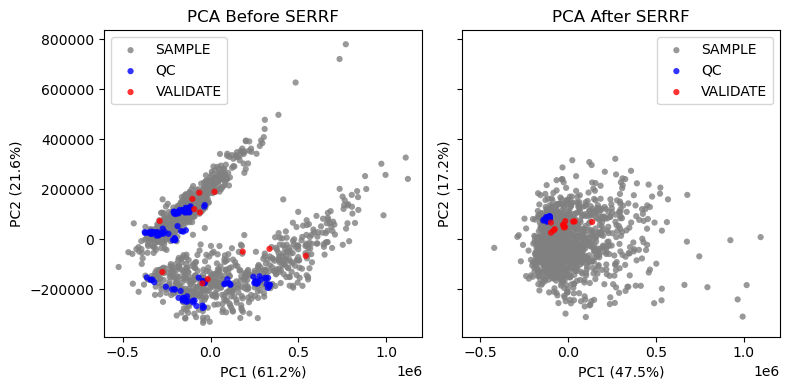

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# — prepare metadata & colors (same as before) —
meta = pd.DataFrame(
    df_raw.columns.tolist(),
    columns=df_raw.columns.names,
    index=df_raw.columns
)
sample_types = meta['sampleType'].str.lower()
color_map    = {'qc':'blue', 'validate':'red', 'sample':'grey'}
plot_order   = ['sample','qc','validate']

# — compute PCA coords —
pca_raw   = PCA(n_components=2, random_state=0)
coords_raw = pca_raw.fit_transform(df_raw.T)

pca_corr    = PCA(n_components=2, random_state=0)
coords_corr = pca_corr.fit_transform(df_corrected.T)

# — set up side‐by‐side axes —
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

def draw_pca(ax, coords, pca, title):
    for z, grp in enumerate(plot_order, start=1):
        mask = sample_types == grp
        ax.scatter(
            coords[mask, 0],
            coords[mask, 1],
            c=color_map[grp],
            label=grp.upper(),
            s=20,
            alpha=0.8,
            edgecolors='none',
            zorder=z
        )
    ax.set_title(title)
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    ax.legend()

# — draw each panel —
draw_pca(axes[0], coords_raw,  pca_raw,  'PCA Before SERRF')
draw_pca(axes[1], coords_corr, pca_corr, 'PCA After SERRF')

plt.tight_layout()
plt.savefig('../plots/serrf-gpt.svg', bbox_inches='tight')
plt.show()
